# MAT10000 Cancer Dataset


### Dataset taken from

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T


### 
Copied from the above webpage...

Training of neural networks for automated diagnosis of pigmented skin lesions is hampered by the small size and lack of diversity of available dataset of dermatoscopic images. We tackle this problem by releasing the HAM10000 ("Human Against Machine with 10000 training images") dataset. We collected dermatoscopic images from different populations, acquired and stored by different modalities. The final dataset consists of 10015 dermatoscopic images which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

Due to upload size limitations, images are stored in two files:

HAM10000_images_part1.zip (5000 JPEG files)
HAM10000_images_part2.zip (5015 JPEG files)

### Step involved in this project:

(1) Importing essential libraries

(2) Creting directories for train and test

Step 3: Reading and Processing Data

Step 4: Data Cleaning

Step 5: Exploratory data analysis (EDA)

Step 6: Loading & Resizing of images

Step 7: Train Test Split

Step 8: Normalization

Step 9: Label Encoding

Step 10: Train validation split

Step 11: Model Building (CNN)

Step 12: Setting Optimizer & Annealing

Step 13: Fitting the model

Step 14: Model Evaluation (Testing and validation accuracy, confusion matrix, analysis of misclassified instances)



In [1]:
# gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sun Apr 18 19:12:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 18 19:12:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"{ram_gb} GB")

27.3937408 GB


In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
# function ClickConnect(){
# console.log("Working"); 
# document.querySelector("colab-toolbar-button#connect").click() 
# }
# setInterval(ClickConnect,60000)

# See some pics


In [6]:
# Calling all libraries

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid
import torch.optim as optim

import os
from PIL import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')
torch.manual_seed(42)

print('All loaded')

All loaded


In [7]:
# reading metadata from excel file
# local_dir = '/Users/khan_m_a/Downloads/programs_data/skin_cancer/'
local_dir = '/content/drive/MyDrive/Data_Science/projects/skin_lesions_HAM10000/'

print(os.listdir(local_dir))
df = pd.read_csv(os.path.join(local_dir, 'HAM10000_metadata.csv'))
df.head(3)

['Good_Skin-Lesion-Classifier-master', 'HAM10000_metadata.csv', 'skin-cancer-dl-model-688b51644741.json', 'MAT10000_3_17.h5', 'MAT10000_EDA_Modelling 3_23.ipynb', 'MAT10000_EDA_Modelling 4_1.ipynb', 'MAT10000_3_31.h5', 'data_dir', 'MAT10000_EDA.ipynb', 'HAM10000_4_7.h5', 'HAM10000_model.ipynb', 'deploy model', 'MAT1000_pytorch_4_15.ipynb', 'skin_lesion_pytorch_4_14.ipynb', 'MAT10000_4_7.h5', 'skin_lesions_HAM10000_pytorch.ipynb', 'skin_lesions_HAM10000_tf.ipynb']


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp


Image shape is (450, 600, 3)


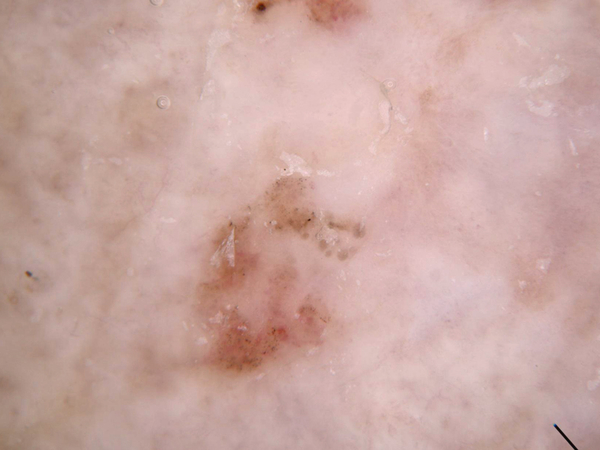

In [8]:
# check a sample from the train 

# local_dir = '/content/drive/MyDrive/Data_Science/projects/MAT10000_skin_cancer/data_dir/'

with Image.open(local_dir + '/data_dir/train/akiec/'+'ISIC_0024329.jpg' ) as im:
    print(f'Image shape is {np.asarray(im).shape}')
    display(im)

In [9]:
# checking total number of images

img_names = []

for folder, subfolder, filenames in os.walk(local_dir):
    
    for im in filenames:
        img_names.append(im)

print(f'The total number of images are {len(img_names)}')

The total number of images are 10053


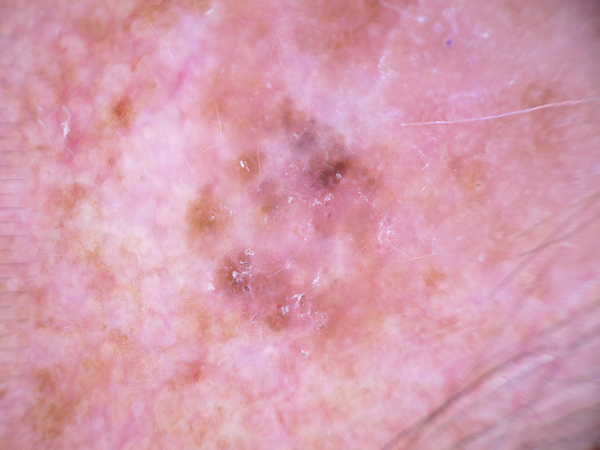

The size of the pic is (600, 450)
Value of 0,0 pixel (186, 128, 140)


In [10]:
cancer_cell = Image.open(local_dir + 'data_dir/train/bkl/'+'ISIC_0026769.jpg' )
display(cancer_cell)
print(f'The size of the pic is {cancer_cell.size}') #(w, h)
print(f'Value of 0,0 pixel', cancer_cell.getpixel((0,0)))

In [11]:
# transfor the image to tensor

transform = transforms.Compose([
                    transforms.ToTensor() 
                                ])

im = transform(cancer_cell)
print(type(im))
print(im.shape) # (channel, h, w)

<class 'torch.Tensor'>
torch.Size([3, 450, 600])


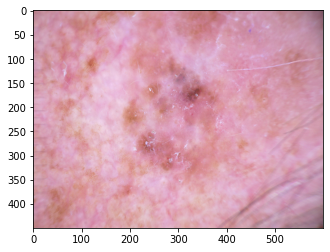

In [12]:
# transpose to (h, w, ch)

plt.imshow(np.transpose(im.numpy(), (1,2,0))) # transpose

In [13]:
im[:, 0 ,0] # Tensor object has been normalized

tensor([0.7294, 0.5020, 0.5490])

In [14]:
np.array((186, 128, 140))/255. # checking with the original ones


array([0.72941176, 0.50196078, 0.54901961])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


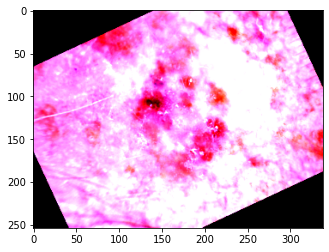

In [15]:
# Resize, CenterCrop using transform

transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p = 0.9),
                    transforms.RandomRotation(30),
                    transforms.Resize(254),
                    # transforms.CenterCrop(254),
                    transforms.ToTensor(),
                    # pre trained model use these mean and std values
                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
                                ])

im = transform(cancer_cell)
plt.imshow(np.transpose(im.numpy(), (1,2,0))) # transpose


## Image Augumentation


In [16]:
# transform the pictures from train and test
img_sz = 450

train_transform = transforms.Compose([
                    transforms.RandomHorizontalFlip(p = 0.5),
                    transforms.RandomRotation(10),
                    transforms.Resize(img_sz), #254
                    transforms.CenterCrop(img_sz),
                    transforms.ToTensor(),
                    # pre trained model use these mean and std values
                    
                    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225]) 
                    # transforms.Normalize(mean= [0.5, 0.5, 0.5], std= [0.5,0.5, 0.5])
                                ])

test_transform = transforms.Compose([
                    # transforms.RandomHorizontalFlip(p = 0.5),
                    # transforms.RandomRotation(10),
                    transforms.Resize(img_sz), #254
                    transforms.CenterCrop(img_sz),
                    transforms.ToTensor(),
                    # pre trained model use these mean and std values
                    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225]) 
                    # transforms.Normalize(mean= [0.5, 0.5, 0.5], std= [0.5,0.5, 0.5])
                                ])




In [17]:
# Dataloader using transform
batch_size = 16

train_data = datasets.ImageFolder(os.path.join( local_dir + 'data_dir/', 'train'), transform=train_transform )
test_data = datasets.ImageFolder(os.path.join( local_dir + 'data_dir/', 'test'), transform=test_transform )

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class_names = train_data.classes

In [18]:
class_names

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [19]:
print(len(train_data), len(test_data))

7511 2504


In [20]:
for images, labels in train_loader:
    break

In [21]:
images.shape

torch.Size([16, 3, 450, 450])

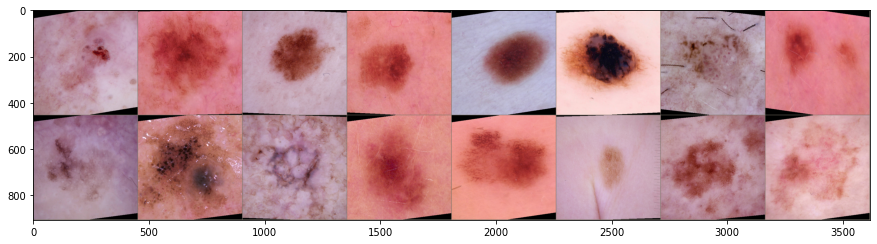

In [22]:
# Visualize some pictures using inverse normalization

im = make_grid(images, nrows=2)

inv_normalize = transforms.Normalize(
                mean = [ -0.485/0.229, -0.456/0.224, -0.406/0.225],
                std= [ 1/0.229, 1/0.224, 1/0.225])

im_inv = inv_normalize(im)
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(im_inv.numpy(), (1,2,0)))
plt.show()


In [23]:

(((img_sz-2)/2)-2)/2


111.0

## Model

In [24]:
# create model 

class ConvolutionalNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # self.fc1   = nn.Linear(62*62*16, 120) # for 254 = (((254-2)/2)-2)/2
        self.fc1   = nn.Linear(111*111*16, 120) 
        self.fc2   = nn.Linear(120, 64)
        self.fc3   = nn.Linear(64, len(class_names))

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 111*111*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)



In [25]:
# calling model

CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(CNNmodel.parameters(), lr = 0.001)

CNNmodel # just like model.summary() in keras

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=197136, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)

In [26]:

for p in CNNmodel.parameters():
    print(p.numel())

162
6
864
16
23656320
120
7680
64
448
7


## Training the model

In [27]:
# print(train_losses)

In [28]:
# print(test_losses)

In [29]:
# # plotting train and test losses

# plt.plot(train_losses, label= 'Training Loss')
# plt.plot(test_losses, label= 'Validation Loss')
# plt.title('Loss at the end of epoch')
# plt.legend();


In [30]:
# # plotting train and test accuracy
# # 30 and 10 beacause we are taking only 300 and 100 batch in each epoch
# plt.plot([t for t in train_corr], label= 'Training Accuracy')
# plt.plot([t for t in test_corr], label= 'Validation Accuracy')

# plt.title('Accuracy at the end of epoch')
# plt.legend();

## Pre-trained Model

In [31]:
# Retrieve alexnet from the models
AlexNetModel = models.alexnet(pretrained= True) 
AlexNetModel

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [32]:
# freeze all layer except the last

for param in AlexNetModel.parameters():
    param.requires_grad = False


In [33]:
torch.manual_seed(42)

AlexNetModel.classifier = nn.Sequential(nn.Linear(9216, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.45),
                                        nn.Linear(1024, 512),
                                        nn.ReLU(),
                                        nn.Dropout(0.45),
                                        nn.Linear(512,7),
                                        nn.LogSoftmax(dim=1)
                                        )


In [34]:
AlexNetModel

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.45,

In [35]:
# count parameter

for param in AlexNetModel.parameters():
    print(param.numel())

23232
64
307200
192
663552
384
884736
256
589824
256
9437184
1024
524288
512
3584
7


In [36]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(AlexNetModel.classifier.parameters(), lr = 0.001)



In [37]:

import time
start_time = time.time()

epochs = 50 #30



train_losses, test_losses = [],[]
train_corr, test_corr = [] , []

for i in range(epochs):
    trn_corr, tst_corr = 0, 0

    for b, (X_train, y_train) in enumerate(train_loader):
        
      
        b+= 1
        # print(f'batch is {b}')
        y_pred = AlexNetModel(X_train)
        loss = criterion(y_pred, y_train)

        #correct predictions
        predicted = torch.max(y_pred.data, 1)[1] # 1 in max will give prob and class. [1] will take only class
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if b% 200 ==0 :
    print(f"Epoch {i+1:2} Loss: {loss.item()}", end = " ")
    total_time = time.time() - start_time
    print(f"Epoch time : {total_time/60} minutes", end = " ")
    print(f"Accuracy {trn_corr.item()*100/(batch_size*b)}")
    
    train_losses.append(loss)
    train_corr.append(trn_corr)

# Test Set

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # to shorten simulation time use this
            # if b == max_te_batch:
            #     break
            
            y_val = AlexNetModel(X_test)

            # count no. of correct
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_corr.append(tst_corr)


total_time = time.time() - start_time
print(f"Total time : {total_time/60} minutes")


Epoch  1 Loss: 0.3406183421611786 Epoch time : 58.77980117003123 minutes Accuracy 68.57712765957447
Epoch  2 Loss: 0.3439352512359619 Epoch time : 85.20688952207566 minutes Accuracy 72.00797872340425
Epoch  3 Loss: 0.6643007397651672 Epoch time : 94.03843606710434 minutes Accuracy 73.11170212765957
Epoch  4 Loss: 0.6502028703689575 Epoch time : 102.89376151561737 minutes Accuracy 74.72074468085107
Epoch  5 Loss: 0.7109932899475098 Epoch time : 111.60929743448894 minutes Accuracy 75.35904255319149
Epoch  6 Loss: 0.0452331081032753 Epoch time : 120.30786041021346 minutes Accuracy 77.04787234042553
Epoch  7 Loss: 0.5490823984146118 Epoch time : 129.1645577987035 minutes Accuracy 77.14095744680851
Epoch  8 Loss: 0.4602338373661041 Epoch time : 137.9407566746076 minutes Accuracy 78.51063829787235
Epoch  9 Loss: 0.7927358746528625 Epoch time : 146.64172868331272 minutes Accuracy 78.08510638297872
Epoch 10 Loss: 0.6105402708053589 Epoch time : 155.16978627443314 minutes Accuracy 78.8297872340

In [38]:
print(train_losses, test_losses)

[tensor(0.3406, grad_fn=<NllLossBackward>), tensor(0.3439, grad_fn=<NllLossBackward>), tensor(0.6643, grad_fn=<NllLossBackward>), tensor(0.6502, grad_fn=<NllLossBackward>), tensor(0.7110, grad_fn=<NllLossBackward>), tensor(0.0452, grad_fn=<NllLossBackward>), tensor(0.5491, grad_fn=<NllLossBackward>), tensor(0.4602, grad_fn=<NllLossBackward>), tensor(0.7927, grad_fn=<NllLossBackward>), tensor(0.6105, grad_fn=<NllLossBackward>), tensor(1.2290, grad_fn=<NllLossBackward>), tensor(0.7013, grad_fn=<NllLossBackward>), tensor(0.6325, grad_fn=<NllLossBackward>), tensor(0.3273, grad_fn=<NllLossBackward>), tensor(0.3144, grad_fn=<NllLossBackward>), tensor(1.1246, grad_fn=<NllLossBackward>), tensor(0.3828, grad_fn=<NllLossBackward>), tensor(1.0222, grad_fn=<NllLossBackward>), tensor(0.1769, grad_fn=<NllLossBackward>), tensor(0.4544, grad_fn=<NllLossBackward>), tensor(0.3155, grad_fn=<NllLossBackward>), tensor(0.6962, grad_fn=<NllLossBackward>), tensor(0.6000, grad_fn=<NllLossBackward>), tensor(1.0

In [39]:
print(train_corr, test_corr)

[tensor(5157), tensor(5415), tensor(5498), tensor(5619), tensor(5667), tensor(5794), tensor(5801), tensor(5904), tensor(5872), tensor(5928), tensor(5939), tensor(6009), tensor(5993), tensor(6071), tensor(6042), tensor(6065), tensor(6066), tensor(6054), tensor(6070), tensor(6127), tensor(6143), tensor(6196), tensor(6166), tensor(6204), tensor(6212), tensor(6242), tensor(6210), tensor(6256), tensor(6207), tensor(6289), tensor(6205), tensor(6245), tensor(6284), tensor(6247), tensor(6327), tensor(6315), tensor(6268), tensor(6322), tensor(6308), tensor(6301), tensor(6239), tensor(6361), tensor(6275), tensor(6380), tensor(6382), tensor(6382), tensor(6399), tensor(6422), tensor(6416), tensor(6365)] [tensor(1732), tensor(1785), tensor(1801), tensor(1793), tensor(1822), tensor(1829), tensor(1888), tensor(1883), tensor(1872), tensor(1857), tensor(1908), tensor(1907), tensor(1872), tensor(1879), tensor(1850), tensor(1863), tensor(1865), tensor(1904), tensor(1906), tensor(1866), tensor(1893), tens

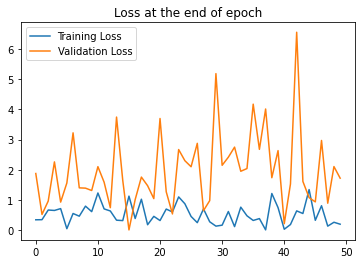

In [40]:
# plotting train and test losses

plt.plot(train_losses, label= 'Training Loss')
plt.plot(test_losses, label= 'Validation Loss')
plt.title('Loss at the end of epoch')
plt.legend();

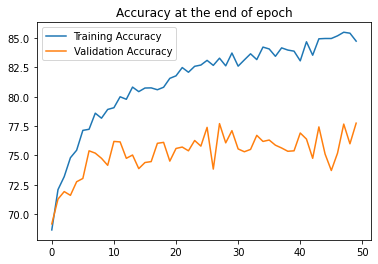

In [41]:
# plotting train and test accuracy
# 30 and 10 beacause we are taking only 300 and 100 batch in each epoch
plt.plot([t*100/len(train_data) for t in train_corr], label= 'Training Accuracy')
plt.plot([t*100/len(test_data)  for t in test_corr], label= 'Validation Accuracy')

plt.title('Accuracy at the end of epoch')
plt.legend();

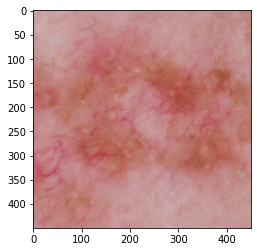

In [42]:
# check an image with both the models

image_index = 30

im = inv_normalize(test_data[image_index][0])
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [43]:
# prediction from Conv model

# CNNmodel.eval()
# with torch.no_grad():
#     cnn_pred = CNNmodel(test_data[image_index][0].view(1, 3, 254, 254)).argmax()

# class_names[cnn_pred]

In [44]:
# prediction from Alexnet model

AlexNetModel.eval()
with torch.no_grad():
    anet_pred = AlexNetModel(test_data[image_index][0].view(1, 3, img_sz, img_sz)).argmax()

class_names[anet_pred]

'akiec'